In [2]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from tqdm import tqdm

import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self, N=1000,cut_off = 20, activation_type = None):
        super(Net, self).__init__()
        self.particle_num = N
        
        if activation_type == 'ReLU':
            self.activation = nn.ReLU()
        elif activation_type == 'Sigmoid':
            self.activation = nn.Sigmoid()
            
        self.fc1 = nn.Linear(2, N)
        self.fc2 = nn.Linear(N, 1, bias=False)
        
        nn.init.normal_(self.fc1.weight, mean=0, std=5)
        nn.init.normal_(self.fc1.bias, mean=0, std=5)
        nn.init.normal_(self.fc2.weight, mean=0, std=5)
        
        self.cut_off = cut_off

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        # restrict the weights of fc2 to be within [0, cutoff]
        
        if self.cut_off != None:
            self.fc2.weight.data = torch.clamp(self.fc2.weight.data, min=-self.cut_off, max=self.cut_off)
            
        x = self.fc2(x)/self.particle_num 
        
        return x.squeeze()

class FullGradientDescentWithNoisyAndWeightDecay(torch.optim.Optimizer):
    def __init__(self, params, N, lr=1e-3, weight_decay=0, noise_scale=0):
        defaults = dict(lr=lr, weight_decay=weight_decay, noise_scale=noise_scale)
        self.N =  N
        super(FullGradientDescentWithNoisyAndWeightDecay, self).__init__(params, defaults)
        
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']
            noise_scale = group['noise_scale']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data * self.N
                
                if weight_decay != 0:
                    grad.add_(weight_decay, p.data)
                
                p.data.add_(-lr, grad)
                
                if noise_scale != 0:
                    noise = torch.randn_like(p.data) * noise_scale * (lr ** 1/2)
                    p.data.add_(noise)
        
        return loss

In [4]:
def target_func(v):
    return np.sin(2 * np.pi * v[:,0]) + np.cos(2 * np.pi * v[:,1])

# Assuming you have input_data and target_data tensors
input_data =  torch.rand(1000,2)  # shape: (num_samples, input_size)
target_data =target_func(input_data)  # shape: (num_samples, target_size)

# Create a TensorDataset object with your data tensors
dataset = TensorDataset(input_data, target_data)

def trainloss(x, y):
    return (x - y) ** 2 / 2

In [5]:
train_loader = torch.utils.data.DataLoader(dataset,
    batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)


In [6]:
weight_decay = 0.00001
sigma = 1

lr = 0.2 # KL lr = 0.5  MSE 0.1

particle_num = 128
cut_off = 100

activation_type = 'Sigmoid' # relu as default
loss_type = 'MSE'

In [19]:
output_result = True

test_var = 'particle_num'
test_values = [64,128,256,512,1024]
# test_values = [256]

test_time_per_objective = 10

result_trainloss_set = []
result_L2_trainloss_set = []
result_testacc_set = []

for test_value in test_values:
    globals()[test_var] = test_value
    
    trainloss_current = []
    L2_trainloss_current = []
    
    criterion = nn.MSELoss()
    
    for test_number in tqdm(range(test_time_per_objective)):
        # Define the loss function and optimizer
        net = Net(N=particle_num,cut_off=cut_off,activation_type =activation_type).to(device)

        optimizer = FullGradientDescentWithNoisyAndWeightDecay(net.parameters(),particle_num, lr=lr,
                                                                weight_decay = weight_decay, noise_scale = sigma)
        # optimizer = torch.optim.SGD(net.parameters(), lr=lr)
        # Train the network
        epochs = 20000
        train_losses = []
        L2_train_losses = []
        
        net.train()
        
        for epoch in range(1, epochs + 1):
            train_loss = 0.0
            
            optimizer.zero_grad()
            output = net(data)

            # loss =  trainloss(output, target).mean()
            loss = trainloss(output, target).mean()

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0) 
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            squared_sum = 0
            for param in net.parameters():
                squared_sum += torch.sum(param.data ** 2) / particle_num

            L2_trian_loss = train_loss + squared_sum.item() * weight_decay
            L2_train_losses.append(L2_trian_loss)

            if (epoch == 1 or epoch % 1000 == 0) and output_result:
                print('Epoch: {} Train Loss: {:.6f} L2-Train Loss: {:.6f}'.format(
                    epoch, train_loss, L2_trian_loss))
                
        trainloss_current.append(train_losses)
        L2_trainloss_current.append(L2_train_losses)

    result_trainloss_set.append(trainloss_current)
    result_L2_trainloss_set.append(L2_trainloss_current)
    
    avg_trainloss_cur = np.mean(np.array(trainloss_current)[:,-500:])
    avg_L2_trainloss =  np.mean(np.array(L2_trainloss_current)[:,-500:])
    
    print('Finish test %s=%d'%(test_var,globals()[test_var]),'cutoff = %.2f'%(cut_off),
          'avg_trainloss=%.3e'%(avg_trainloss_cur), 
          'avg_L2_trainloss=%.3e'%(avg_L2_trainloss))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.471869 L2-Train Loss: 0.472851
Epoch: 1000 Train Loss: 0.081808 L2-Train Loss: 0.083971
Epoch: 2000 Train Loss: 0.025391 L2-Train Loss: 0.028876
Epoch: 3000 Train Loss: 0.019669 L2-Train Loss: 0.023997
Epoch: 4000 Train Loss: 0.013480 L2-Train Loss: 0.018792
Epoch: 5000 Train Loss: 0.013781 L2-Train Loss: 0.019969
Epoch: 6000 Train Loss: 0.012353 L2-Train Loss: 0.018957
Epoch: 7000 Train Loss: 0.011965 L2-Train Loss: 0.018700
Epoch: 8000 Train Loss: 0.013130 L2-Train Loss: 0.020174
Epoch: 9000 Train Loss: 0.008548 L2-Train Loss: 0.016018
Epoch: 10000 Train Loss: 0.007652 L2-Train Loss: 0.015290
Epoch: 11000 Train Loss: 0.007442 L2-Train Loss: 0.015615
Epoch: 12000 Train Loss: 0.006997 L2-Train Loss: 0.015609
Epoch: 13000 Train Loss: 0.007480 L2-Train Loss: 0.016579
Epoch: 14000 Train Loss: 0.007054 L2-Train Loss: 0.016688
Epoch: 15000 Train Loss: 0.006558 L2-Train Loss: 0.016691
Epoch: 16000 Train Loss: 0.007385 L2-Train Loss: 0.017823
Epoch: 17000 Train Loss: 0.

 10%|████████▎                                                                          | 1/10 [00:52<07:49, 52.20s/it]

Epoch: 20000 Train Loss: 0.007449 L2-Train Loss: 0.019007
Epoch: 1 Train Loss: 0.581867 L2-Train Loss: 0.582823
Epoch: 1000 Train Loss: 0.068002 L2-Train Loss: 0.070321
Epoch: 2000 Train Loss: 0.035251 L2-Train Loss: 0.038507
Epoch: 3000 Train Loss: 0.020797 L2-Train Loss: 0.024775
Epoch: 4000 Train Loss: 0.015126 L2-Train Loss: 0.019875
Epoch: 5000 Train Loss: 0.016485 L2-Train Loss: 0.022043
Epoch: 6000 Train Loss: 0.012484 L2-Train Loss: 0.018603
Epoch: 7000 Train Loss: 0.011006 L2-Train Loss: 0.017650
Epoch: 8000 Train Loss: 0.006813 L2-Train Loss: 0.013904
Epoch: 9000 Train Loss: 0.010391 L2-Train Loss: 0.017621
Epoch: 10000 Train Loss: 0.009216 L2-Train Loss: 0.016922
Epoch: 11000 Train Loss: 0.008178 L2-Train Loss: 0.016768
Epoch: 12000 Train Loss: 0.007109 L2-Train Loss: 0.016068
Epoch: 13000 Train Loss: 0.008068 L2-Train Loss: 0.017332
Epoch: 14000 Train Loss: 0.009974 L2-Train Loss: 0.020073
Epoch: 15000 Train Loss: 0.004187 L2-Train Loss: 0.014893
Epoch: 16000 Train Loss: 0.

 20%|████████████████▌                                                                  | 2/10 [01:44<06:56, 52.02s/it]

Epoch: 20000 Train Loss: 0.007068 L2-Train Loss: 0.019174
Epoch: 1 Train Loss: 0.635605 L2-Train Loss: 0.636696
Epoch: 1000 Train Loss: 0.090623 L2-Train Loss: 0.093070
Epoch: 2000 Train Loss: 0.040048 L2-Train Loss: 0.043651
Epoch: 3000 Train Loss: 0.022386 L2-Train Loss: 0.026694
Epoch: 4000 Train Loss: 0.020338 L2-Train Loss: 0.025128
Epoch: 5000 Train Loss: 0.018029 L2-Train Loss: 0.023185
Epoch: 6000 Train Loss: 0.015307 L2-Train Loss: 0.020956
Epoch: 7000 Train Loss: 0.011557 L2-Train Loss: 0.018023
Epoch: 8000 Train Loss: 0.010617 L2-Train Loss: 0.017862
Epoch: 9000 Train Loss: 0.007555 L2-Train Loss: 0.015423
Epoch: 10000 Train Loss: 0.009112 L2-Train Loss: 0.017426
Epoch: 11000 Train Loss: 0.010132 L2-Train Loss: 0.019039
Epoch: 12000 Train Loss: 0.008461 L2-Train Loss: 0.017570
Epoch: 13000 Train Loss: 0.008432 L2-Train Loss: 0.018042
Epoch: 14000 Train Loss: 0.007449 L2-Train Loss: 0.017218
Epoch: 15000 Train Loss: 0.010589 L2-Train Loss: 0.020908
Epoch: 16000 Train Loss: 0.

 30%|████████████████████████▉                                                          | 3/10 [02:35<06:02, 51.82s/it]

Epoch: 20000 Train Loss: 0.012695 L2-Train Loss: 0.024759
Epoch: 1 Train Loss: 0.506730 L2-Train Loss: 0.507764
Epoch: 1000 Train Loss: 0.060315 L2-Train Loss: 0.062635
Epoch: 2000 Train Loss: 0.026187 L2-Train Loss: 0.029489
Epoch: 3000 Train Loss: 0.015779 L2-Train Loss: 0.019849
Epoch: 4000 Train Loss: 0.014859 L2-Train Loss: 0.019549
Epoch: 5000 Train Loss: 0.014010 L2-Train Loss: 0.019144
Epoch: 6000 Train Loss: 0.007449 L2-Train Loss: 0.013184
Epoch: 7000 Train Loss: 0.007354 L2-Train Loss: 0.013538
Epoch: 8000 Train Loss: 0.005470 L2-Train Loss: 0.012418
Epoch: 9000 Train Loss: 0.007562 L2-Train Loss: 0.014909
Epoch: 10000 Train Loss: 0.008492 L2-Train Loss: 0.016309
Epoch: 11000 Train Loss: 0.007149 L2-Train Loss: 0.014922
Epoch: 12000 Train Loss: 0.005706 L2-Train Loss: 0.013890
Epoch: 13000 Train Loss: 0.006909 L2-Train Loss: 0.015673
Epoch: 14000 Train Loss: 0.007277 L2-Train Loss: 0.016547
Epoch: 15000 Train Loss: 0.005746 L2-Train Loss: 0.015168
Epoch: 16000 Train Loss: 0.

 40%|█████████████████████████████████▏                                                 | 4/10 [03:29<05:14, 52.49s/it]

Epoch: 20000 Train Loss: 0.008834 L2-Train Loss: 0.019732
Epoch: 1 Train Loss: 0.729465 L2-Train Loss: 0.730435
Epoch: 1000 Train Loss: 0.064339 L2-Train Loss: 0.066775
Epoch: 2000 Train Loss: 0.029392 L2-Train Loss: 0.032759
Epoch: 3000 Train Loss: 0.018558 L2-Train Loss: 0.022848
Epoch: 4000 Train Loss: 0.013303 L2-Train Loss: 0.018469
Epoch: 5000 Train Loss: 0.013081 L2-Train Loss: 0.019134
Epoch: 6000 Train Loss: 0.009212 L2-Train Loss: 0.015631
Epoch: 7000 Train Loss: 0.009510 L2-Train Loss: 0.016903
Epoch: 8000 Train Loss: 0.007929 L2-Train Loss: 0.015924
Epoch: 9000 Train Loss: 0.006815 L2-Train Loss: 0.015052
Epoch: 10000 Train Loss: 0.006347 L2-Train Loss: 0.015232
Epoch: 11000 Train Loss: 0.006301 L2-Train Loss: 0.015790
Epoch: 12000 Train Loss: 0.007740 L2-Train Loss: 0.017981
Epoch: 13000 Train Loss: 0.010927 L2-Train Loss: 0.021360
Epoch: 14000 Train Loss: 0.006242 L2-Train Loss: 0.017072
Epoch: 15000 Train Loss: 0.006582 L2-Train Loss: 0.017774
Epoch: 16000 Train Loss: 0.

 50%|█████████████████████████████████████████▌                                         | 5/10 [04:21<04:22, 52.42s/it]

Epoch: 20000 Train Loss: 0.008274 L2-Train Loss: 0.021825
Epoch: 1 Train Loss: 0.427526 L2-Train Loss: 0.428426
Epoch: 1000 Train Loss: 0.109685 L2-Train Loss: 0.111703
Epoch: 2000 Train Loss: 0.023958 L2-Train Loss: 0.027210
Epoch: 3000 Train Loss: 0.015823 L2-Train Loss: 0.019883
Epoch: 4000 Train Loss: 0.015186 L2-Train Loss: 0.019873
Epoch: 5000 Train Loss: 0.014989 L2-Train Loss: 0.020312
Epoch: 6000 Train Loss: 0.013061 L2-Train Loss: 0.018790
Epoch: 7000 Train Loss: 0.010014 L2-Train Loss: 0.016497
Epoch: 8000 Train Loss: 0.010994 L2-Train Loss: 0.017567
Epoch: 9000 Train Loss: 0.008848 L2-Train Loss: 0.015872
Epoch: 10000 Train Loss: 0.007266 L2-Train Loss: 0.014582
Epoch: 11000 Train Loss: 0.005718 L2-Train Loss: 0.013830
Epoch: 12000 Train Loss: 0.007169 L2-Train Loss: 0.015683
Epoch: 13000 Train Loss: 0.008310 L2-Train Loss: 0.017336
Epoch: 14000 Train Loss: 0.009321 L2-Train Loss: 0.018694
Epoch: 15000 Train Loss: 0.008391 L2-Train Loss: 0.018457
Epoch: 16000 Train Loss: 0.

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:13<03:28, 52.17s/it]

Epoch: 20000 Train Loss: 0.009638 L2-Train Loss: 0.021815
Epoch: 1 Train Loss: 0.573967 L2-Train Loss: 0.574980
Epoch: 1000 Train Loss: 0.077662 L2-Train Loss: 0.080073
Epoch: 2000 Train Loss: 0.029196 L2-Train Loss: 0.032797
Epoch: 3000 Train Loss: 0.021407 L2-Train Loss: 0.025618
Epoch: 4000 Train Loss: 0.022284 L2-Train Loss: 0.027088
Epoch: 5000 Train Loss: 0.021695 L2-Train Loss: 0.026900
Epoch: 6000 Train Loss: 0.017478 L2-Train Loss: 0.023457
Epoch: 7000 Train Loss: 0.013763 L2-Train Loss: 0.020536
Epoch: 8000 Train Loss: 0.014486 L2-Train Loss: 0.021872
Epoch: 9000 Train Loss: 0.008098 L2-Train Loss: 0.015922
Epoch: 10000 Train Loss: 0.007406 L2-Train Loss: 0.015542
Epoch: 11000 Train Loss: 0.009799 L2-Train Loss: 0.018231
Epoch: 12000 Train Loss: 0.007658 L2-Train Loss: 0.016223
Epoch: 13000 Train Loss: 0.007478 L2-Train Loss: 0.016576
Epoch: 14000 Train Loss: 0.005651 L2-Train Loss: 0.015304
Epoch: 15000 Train Loss: 0.005318 L2-Train Loss: 0.015350
Epoch: 16000 Train Loss: 0.

 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:04<02:35, 51.82s/it]

Epoch: 20000 Train Loss: 0.008173 L2-Train Loss: 0.020000
Epoch: 1 Train Loss: 0.538153 L2-Train Loss: 0.539000
Epoch: 1000 Train Loss: 0.060432 L2-Train Loss: 0.062660
Epoch: 2000 Train Loss: 0.027842 L2-Train Loss: 0.031183
Epoch: 3000 Train Loss: 0.021507 L2-Train Loss: 0.025724
Epoch: 4000 Train Loss: 0.014516 L2-Train Loss: 0.019316
Epoch: 5000 Train Loss: 0.015478 L2-Train Loss: 0.021013
Epoch: 6000 Train Loss: 0.010834 L2-Train Loss: 0.016762
Epoch: 7000 Train Loss: 0.008991 L2-Train Loss: 0.015440
Epoch: 8000 Train Loss: 0.010393 L2-Train Loss: 0.017268
Epoch: 9000 Train Loss: 0.010774 L2-Train Loss: 0.017982
Epoch: 10000 Train Loss: 0.009180 L2-Train Loss: 0.016676
Epoch: 11000 Train Loss: 0.006711 L2-Train Loss: 0.015078
Epoch: 12000 Train Loss: 0.007242 L2-Train Loss: 0.015621
Epoch: 13000 Train Loss: 0.006309 L2-Train Loss: 0.014756
Epoch: 14000 Train Loss: 0.011216 L2-Train Loss: 0.020207
Epoch: 15000 Train Loss: 0.007369 L2-Train Loss: 0.016680
Epoch: 16000 Train Loss: 0.

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:56<01:43, 51.83s/it]

Epoch: 20000 Train Loss: 0.006021 L2-Train Loss: 0.017723
Epoch: 1 Train Loss: 0.508220 L2-Train Loss: 0.509303
Epoch: 1000 Train Loss: 0.082547 L2-Train Loss: 0.085016
Epoch: 2000 Train Loss: 0.027047 L2-Train Loss: 0.030651
Epoch: 3000 Train Loss: 0.018012 L2-Train Loss: 0.022360
Epoch: 4000 Train Loss: 0.018245 L2-Train Loss: 0.023192
Epoch: 5000 Train Loss: 0.011072 L2-Train Loss: 0.016662
Epoch: 6000 Train Loss: 0.012631 L2-Train Loss: 0.018602
Epoch: 7000 Train Loss: 0.010312 L2-Train Loss: 0.016739
Epoch: 8000 Train Loss: 0.012558 L2-Train Loss: 0.019441
Epoch: 9000 Train Loss: 0.009017 L2-Train Loss: 0.016370
Epoch: 10000 Train Loss: 0.007210 L2-Train Loss: 0.015511
Epoch: 11000 Train Loss: 0.005912 L2-Train Loss: 0.014164
Epoch: 12000 Train Loss: 0.010977 L2-Train Loss: 0.019385
Epoch: 13000 Train Loss: 0.007668 L2-Train Loss: 0.016461
Epoch: 14000 Train Loss: 0.006968 L2-Train Loss: 0.016480
Epoch: 15000 Train Loss: 0.007257 L2-Train Loss: 0.017480
Epoch: 16000 Train Loss: 0.

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:47<00:51, 51.82s/it]

Epoch: 20000 Train Loss: 0.008552 L2-Train Loss: 0.020384
Epoch: 1 Train Loss: 0.612023 L2-Train Loss: 0.612840
Epoch: 1000 Train Loss: 0.089747 L2-Train Loss: 0.091847
Epoch: 2000 Train Loss: 0.031198 L2-Train Loss: 0.034397
Epoch: 3000 Train Loss: 0.018717 L2-Train Loss: 0.022747
Epoch: 4000 Train Loss: 0.016562 L2-Train Loss: 0.021279
Epoch: 5000 Train Loss: 0.017283 L2-Train Loss: 0.022385
Epoch: 6000 Train Loss: 0.014501 L2-Train Loss: 0.019831
Epoch: 7000 Train Loss: 0.012238 L2-Train Loss: 0.018046
Epoch: 8000 Train Loss: 0.013703 L2-Train Loss: 0.020172
Epoch: 9000 Train Loss: 0.010892 L2-Train Loss: 0.018089
Epoch: 10000 Train Loss: 0.006109 L2-Train Loss: 0.013669
Epoch: 11000 Train Loss: 0.012041 L2-Train Loss: 0.019878
Epoch: 12000 Train Loss: 0.009149 L2-Train Loss: 0.017572
Epoch: 13000 Train Loss: 0.005818 L2-Train Loss: 0.014717
Epoch: 14000 Train Loss: 0.006450 L2-Train Loss: 0.015507
Epoch: 15000 Train Loss: 0.005536 L2-Train Loss: 0.015036
Epoch: 16000 Train Loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:40<00:00, 52.01s/it]


Epoch: 20000 Train Loss: 0.005432 L2-Train Loss: 0.015935
Finish test particle_num=64 cutoff = 100.00 avg_trainloss=7.970e-03 avg_L2_trainloss=1.977e-02


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.571520 L2-Train Loss: 0.572560
Epoch: 1000 Train Loss: 0.084806 L2-Train Loss: 0.087080
Epoch: 2000 Train Loss: 0.028942 L2-Train Loss: 0.032342
Epoch: 3000 Train Loss: 0.017880 L2-Train Loss: 0.022129
Epoch: 4000 Train Loss: 0.014086 L2-Train Loss: 0.019030
Epoch: 5000 Train Loss: 0.009776 L2-Train Loss: 0.015285
Epoch: 6000 Train Loss: 0.007721 L2-Train Loss: 0.013918
Epoch: 7000 Train Loss: 0.006705 L2-Train Loss: 0.013194
Epoch: 8000 Train Loss: 0.004596 L2-Train Loss: 0.011651
Epoch: 9000 Train Loss: 0.004297 L2-Train Loss: 0.011799
Epoch: 10000 Train Loss: 0.004860 L2-Train Loss: 0.012890
Epoch: 11000 Train Loss: 0.004675 L2-Train Loss: 0.013452
Epoch: 12000 Train Loss: 0.004613 L2-Train Loss: 0.013938
Epoch: 13000 Train Loss: 0.006733 L2-Train Loss: 0.016669
Epoch: 14000 Train Loss: 0.005133 L2-Train Loss: 0.015351
Epoch: 15000 Train Loss: 0.005302 L2-Train Loss: 0.016014
Epoch: 16000 Train Loss: 0.004435 L2-Train Loss: 0.015679
Epoch: 17000 Train Loss: 0.

 10%|████████▎                                                                          | 1/10 [00:51<07:45, 51.70s/it]

Epoch: 20000 Train Loss: 0.004488 L2-Train Loss: 0.017250
Epoch: 1 Train Loss: 0.652482 L2-Train Loss: 0.653451
Epoch: 1000 Train Loss: 0.080200 L2-Train Loss: 0.082461
Epoch: 2000 Train Loss: 0.030341 L2-Train Loss: 0.033571
Epoch: 3000 Train Loss: 0.019358 L2-Train Loss: 0.023402
Epoch: 4000 Train Loss: 0.017235 L2-Train Loss: 0.021899
Epoch: 5000 Train Loss: 0.011938 L2-Train Loss: 0.017673
Epoch: 6000 Train Loss: 0.009158 L2-Train Loss: 0.015392
Epoch: 7000 Train Loss: 0.010026 L2-Train Loss: 0.016860
Epoch: 8000 Train Loss: 0.005659 L2-Train Loss: 0.013035
Epoch: 9000 Train Loss: 0.005069 L2-Train Loss: 0.012816
Epoch: 10000 Train Loss: 0.006887 L2-Train Loss: 0.015153
Epoch: 11000 Train Loss: 0.004976 L2-Train Loss: 0.013731
Epoch: 12000 Train Loss: 0.005029 L2-Train Loss: 0.014395
Epoch: 13000 Train Loss: 0.004581 L2-Train Loss: 0.014335
Epoch: 14000 Train Loss: 0.004643 L2-Train Loss: 0.014494
Epoch: 15000 Train Loss: 0.004578 L2-Train Loss: 0.014741
Epoch: 16000 Train Loss: 0.

 20%|████████████████▌                                                                  | 2/10 [01:43<06:52, 51.58s/it]

Epoch: 20000 Train Loss: 0.005355 L2-Train Loss: 0.018344
Epoch: 1 Train Loss: 0.586148 L2-Train Loss: 0.587134
Epoch: 1000 Train Loss: 0.078250 L2-Train Loss: 0.080596
Epoch: 2000 Train Loss: 0.021046 L2-Train Loss: 0.024638
Epoch: 3000 Train Loss: 0.014745 L2-Train Loss: 0.019016
Epoch: 4000 Train Loss: 0.011529 L2-Train Loss: 0.016340
Epoch: 5000 Train Loss: 0.010423 L2-Train Loss: 0.015783
Epoch: 6000 Train Loss: 0.007658 L2-Train Loss: 0.013477
Epoch: 7000 Train Loss: 0.007714 L2-Train Loss: 0.014070
Epoch: 8000 Train Loss: 0.005894 L2-Train Loss: 0.012732
Epoch: 9000 Train Loss: 0.006473 L2-Train Loss: 0.014043
Epoch: 10000 Train Loss: 0.004534 L2-Train Loss: 0.012710
Epoch: 11000 Train Loss: 0.003494 L2-Train Loss: 0.012071
Epoch: 12000 Train Loss: 0.005862 L2-Train Loss: 0.015175
Epoch: 13000 Train Loss: 0.005025 L2-Train Loss: 0.014848
Epoch: 14000 Train Loss: 0.005291 L2-Train Loss: 0.015329
Epoch: 15000 Train Loss: 0.005020 L2-Train Loss: 0.015453
Epoch: 16000 Train Loss: 0.

 30%|████████████████████████▉                                                          | 3/10 [02:34<06:01, 51.65s/it]

Epoch: 20000 Train Loss: 0.003284 L2-Train Loss: 0.015302
Epoch: 1 Train Loss: 0.562291 L2-Train Loss: 0.563337
Epoch: 1000 Train Loss: 0.074085 L2-Train Loss: 0.076318
Epoch: 2000 Train Loss: 0.026254 L2-Train Loss: 0.029576
Epoch: 3000 Train Loss: 0.016339 L2-Train Loss: 0.020448
Epoch: 4000 Train Loss: 0.015654 L2-Train Loss: 0.020311
Epoch: 5000 Train Loss: 0.011962 L2-Train Loss: 0.017277
Epoch: 6000 Train Loss: 0.009514 L2-Train Loss: 0.015282
Epoch: 7000 Train Loss: 0.008058 L2-Train Loss: 0.014333
Epoch: 8000 Train Loss: 0.007339 L2-Train Loss: 0.014265
Epoch: 9000 Train Loss: 0.004888 L2-Train Loss: 0.012498
Epoch: 10000 Train Loss: 0.004508 L2-Train Loss: 0.012519
Epoch: 11000 Train Loss: 0.005883 L2-Train Loss: 0.014106
Epoch: 12000 Train Loss: 0.005154 L2-Train Loss: 0.013946
Epoch: 13000 Train Loss: 0.004584 L2-Train Loss: 0.013671
Epoch: 14000 Train Loss: 0.005361 L2-Train Loss: 0.015094
Epoch: 15000 Train Loss: 0.005009 L2-Train Loss: 0.015163
Epoch: 16000 Train Loss: 0.

 40%|█████████████████████████████████▏                                                 | 4/10 [03:26<05:09, 51.50s/it]

Epoch: 20000 Train Loss: 0.003946 L2-Train Loss: 0.016925
Epoch: 1 Train Loss: 0.667122 L2-Train Loss: 0.668084
Epoch: 1000 Train Loss: 0.069045 L2-Train Loss: 0.071439
Epoch: 2000 Train Loss: 0.031050 L2-Train Loss: 0.034413
Epoch: 3000 Train Loss: 0.019737 L2-Train Loss: 0.024001
Epoch: 4000 Train Loss: 0.016243 L2-Train Loss: 0.021084
Epoch: 5000 Train Loss: 0.012238 L2-Train Loss: 0.017613
Epoch: 6000 Train Loss: 0.010490 L2-Train Loss: 0.016658
Epoch: 7000 Train Loss: 0.009695 L2-Train Loss: 0.016331
Epoch: 8000 Train Loss: 0.010183 L2-Train Loss: 0.017399
Epoch: 9000 Train Loss: 0.007867 L2-Train Loss: 0.015692
Epoch: 10000 Train Loss: 0.005753 L2-Train Loss: 0.013963
Epoch: 11000 Train Loss: 0.004401 L2-Train Loss: 0.013268
Epoch: 12000 Train Loss: 0.003564 L2-Train Loss: 0.012915
Epoch: 13000 Train Loss: 0.003775 L2-Train Loss: 0.013571
Epoch: 14000 Train Loss: 0.005889 L2-Train Loss: 0.016194
Epoch: 15000 Train Loss: 0.004979 L2-Train Loss: 0.015587
Epoch: 16000 Train Loss: 0.

 50%|█████████████████████████████████████████▌                                         | 5/10 [04:17<04:17, 51.59s/it]

Epoch: 20000 Train Loss: 0.004142 L2-Train Loss: 0.017007
Epoch: 1 Train Loss: 0.547384 L2-Train Loss: 0.548339
Epoch: 1000 Train Loss: 0.074387 L2-Train Loss: 0.076767
Epoch: 2000 Train Loss: 0.032537 L2-Train Loss: 0.035895
Epoch: 3000 Train Loss: 0.021872 L2-Train Loss: 0.026117
Epoch: 4000 Train Loss: 0.017930 L2-Train Loss: 0.022788
Epoch: 5000 Train Loss: 0.014521 L2-Train Loss: 0.019875
Epoch: 6000 Train Loss: 0.012846 L2-Train Loss: 0.018744
Epoch: 7000 Train Loss: 0.009938 L2-Train Loss: 0.016353
Epoch: 8000 Train Loss: 0.006191 L2-Train Loss: 0.013163
Epoch: 9000 Train Loss: 0.005145 L2-Train Loss: 0.012879
Epoch: 10000 Train Loss: 0.004404 L2-Train Loss: 0.012286
Epoch: 11000 Train Loss: 0.003829 L2-Train Loss: 0.011954
Epoch: 12000 Train Loss: 0.004224 L2-Train Loss: 0.013019
Epoch: 13000 Train Loss: 0.005993 L2-Train Loss: 0.015375
Epoch: 14000 Train Loss: 0.006320 L2-Train Loss: 0.015959
Epoch: 15000 Train Loss: 0.005700 L2-Train Loss: 0.015684
Epoch: 16000 Train Loss: 0.

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:09<03:25, 51.48s/it]

Epoch: 20000 Train Loss: 0.004328 L2-Train Loss: 0.016019
Epoch: 1 Train Loss: 0.552933 L2-Train Loss: 0.553914
Epoch: 1000 Train Loss: 0.088941 L2-Train Loss: 0.091186
Epoch: 2000 Train Loss: 0.028839 L2-Train Loss: 0.032159
Epoch: 3000 Train Loss: 0.018850 L2-Train Loss: 0.022908
Epoch: 4000 Train Loss: 0.016254 L2-Train Loss: 0.020997
Epoch: 5000 Train Loss: 0.012334 L2-Train Loss: 0.017715
Epoch: 6000 Train Loss: 0.007499 L2-Train Loss: 0.013301
Epoch: 7000 Train Loss: 0.009110 L2-Train Loss: 0.015473
Epoch: 8000 Train Loss: 0.006505 L2-Train Loss: 0.013187
Epoch: 9000 Train Loss: 0.007081 L2-Train Loss: 0.014333
Epoch: 10000 Train Loss: 0.005779 L2-Train Loss: 0.013606
Epoch: 11000 Train Loss: 0.007412 L2-Train Loss: 0.015643
Epoch: 12000 Train Loss: 0.007063 L2-Train Loss: 0.015733
Epoch: 13000 Train Loss: 0.006014 L2-Train Loss: 0.015459
Epoch: 14000 Train Loss: 0.004606 L2-Train Loss: 0.014470
Epoch: 15000 Train Loss: 0.005481 L2-Train Loss: 0.015790
Epoch: 16000 Train Loss: 0.

 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:00<02:34, 51.47s/it]

Epoch: 20000 Train Loss: 0.005508 L2-Train Loss: 0.017930
Epoch: 1 Train Loss: 0.525244 L2-Train Loss: 0.526287
Epoch: 1000 Train Loss: 0.060827 L2-Train Loss: 0.063256
Epoch: 2000 Train Loss: 0.025777 L2-Train Loss: 0.029312
Epoch: 3000 Train Loss: 0.020166 L2-Train Loss: 0.024288
Epoch: 4000 Train Loss: 0.016128 L2-Train Loss: 0.020861
Epoch: 5000 Train Loss: 0.013472 L2-Train Loss: 0.018814
Epoch: 6000 Train Loss: 0.011216 L2-Train Loss: 0.017177
Epoch: 7000 Train Loss: 0.006311 L2-Train Loss: 0.012935
Epoch: 8000 Train Loss: 0.006326 L2-Train Loss: 0.013719
Epoch: 9000 Train Loss: 0.005781 L2-Train Loss: 0.013912
Epoch: 10000 Train Loss: 0.005170 L2-Train Loss: 0.013872
Epoch: 11000 Train Loss: 0.006150 L2-Train Loss: 0.015369
Epoch: 12000 Train Loss: 0.005045 L2-Train Loss: 0.014813
Epoch: 13000 Train Loss: 0.004534 L2-Train Loss: 0.014656
Epoch: 14000 Train Loss: 0.004155 L2-Train Loss: 0.014730
Epoch: 15000 Train Loss: 0.005989 L2-Train Loss: 0.016833
Epoch: 16000 Train Loss: 0.

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:52<01:43, 51.55s/it]

Epoch: 20000 Train Loss: 0.004693 L2-Train Loss: 0.017821
Epoch: 1 Train Loss: 0.544190 L2-Train Loss: 0.545172
Epoch: 1000 Train Loss: 0.077277 L2-Train Loss: 0.079636
Epoch: 2000 Train Loss: 0.029565 L2-Train Loss: 0.032987
Epoch: 3000 Train Loss: 0.020897 L2-Train Loss: 0.024960
Epoch: 4000 Train Loss: 0.017771 L2-Train Loss: 0.022554
Epoch: 5000 Train Loss: 0.012842 L2-Train Loss: 0.018286
Epoch: 6000 Train Loss: 0.012778 L2-Train Loss: 0.018699
Epoch: 7000 Train Loss: 0.012741 L2-Train Loss: 0.019030
Epoch: 8000 Train Loss: 0.008467 L2-Train Loss: 0.015451
Epoch: 9000 Train Loss: 0.007715 L2-Train Loss: 0.015199
Epoch: 10000 Train Loss: 0.004744 L2-Train Loss: 0.012444
Epoch: 11000 Train Loss: 0.007065 L2-Train Loss: 0.015567
Epoch: 12000 Train Loss: 0.005907 L2-Train Loss: 0.014883
Epoch: 13000 Train Loss: 0.004734 L2-Train Loss: 0.014124
Epoch: 14000 Train Loss: 0.004056 L2-Train Loss: 0.013951
Epoch: 15000 Train Loss: 0.005198 L2-Train Loss: 0.015617
Epoch: 16000 Train Loss: 0.

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:43<00:51, 51.56s/it]

Epoch: 20000 Train Loss: 0.005271 L2-Train Loss: 0.017706
Epoch: 1 Train Loss: 0.502864 L2-Train Loss: 0.503745
Epoch: 1000 Train Loss: 0.080608 L2-Train Loss: 0.082854
Epoch: 2000 Train Loss: 0.030790 L2-Train Loss: 0.034040
Epoch: 3000 Train Loss: 0.022492 L2-Train Loss: 0.026462
Epoch: 4000 Train Loss: 0.016631 L2-Train Loss: 0.021300
Epoch: 5000 Train Loss: 0.012369 L2-Train Loss: 0.017668
Epoch: 6000 Train Loss: 0.010310 L2-Train Loss: 0.016190
Epoch: 7000 Train Loss: 0.008567 L2-Train Loss: 0.014981
Epoch: 8000 Train Loss: 0.006738 L2-Train Loss: 0.013844
Epoch: 9000 Train Loss: 0.004945 L2-Train Loss: 0.012646
Epoch: 10000 Train Loss: 0.004942 L2-Train Loss: 0.013232
Epoch: 11000 Train Loss: 0.004220 L2-Train Loss: 0.012953
Epoch: 12000 Train Loss: 0.002928 L2-Train Loss: 0.011867
Epoch: 13000 Train Loss: 0.003078 L2-Train Loss: 0.012385
Epoch: 14000 Train Loss: 0.003498 L2-Train Loss: 0.013286
Epoch: 15000 Train Loss: 0.004731 L2-Train Loss: 0.014900
Epoch: 16000 Train Loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:35<00:00, 51.54s/it]


Epoch: 20000 Train Loss: 0.004153 L2-Train Loss: 0.016437
Finish test particle_num=128 cutoff = 100.00 avg_trainloss=4.629e-03 avg_L2_trainloss=1.710e-02


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.571904 L2-Train Loss: 0.572873
Epoch: 1000 Train Loss: 0.069225 L2-Train Loss: 0.071602
Epoch: 2000 Train Loss: 0.027103 L2-Train Loss: 0.030512
Epoch: 3000 Train Loss: 0.017849 L2-Train Loss: 0.021964
Epoch: 4000 Train Loss: 0.014708 L2-Train Loss: 0.019451
Epoch: 5000 Train Loss: 0.010870 L2-Train Loss: 0.016245
Epoch: 6000 Train Loss: 0.008832 L2-Train Loss: 0.014626
Epoch: 7000 Train Loss: 0.007816 L2-Train Loss: 0.014159
Epoch: 8000 Train Loss: 0.005588 L2-Train Loss: 0.012540
Epoch: 9000 Train Loss: 0.005102 L2-Train Loss: 0.012617
Epoch: 10000 Train Loss: 0.004112 L2-Train Loss: 0.011964
Epoch: 11000 Train Loss: 0.003215 L2-Train Loss: 0.011466
Epoch: 12000 Train Loss: 0.003694 L2-Train Loss: 0.012401
Epoch: 13000 Train Loss: 0.002232 L2-Train Loss: 0.011394
Epoch: 14000 Train Loss: 0.002965 L2-Train Loss: 0.012526
Epoch: 15000 Train Loss: 0.002956 L2-Train Loss: 0.012941
Epoch: 16000 Train Loss: 0.003330 L2-Train Loss: 0.013518
Epoch: 17000 Train Loss: 0.

 10%|████████▎                                                                          | 1/10 [00:51<07:45, 51.71s/it]

Epoch: 20000 Train Loss: 0.003153 L2-Train Loss: 0.014630
Epoch: 1 Train Loss: 0.573103 L2-Train Loss: 0.574096
Epoch: 1000 Train Loss: 0.072735 L2-Train Loss: 0.075073
Epoch: 2000 Train Loss: 0.025203 L2-Train Loss: 0.028622
Epoch: 3000 Train Loss: 0.017190 L2-Train Loss: 0.021468
Epoch: 4000 Train Loss: 0.012659 L2-Train Loss: 0.017579
Epoch: 5000 Train Loss: 0.008370 L2-Train Loss: 0.013924
Epoch: 6000 Train Loss: 0.007443 L2-Train Loss: 0.013538
Epoch: 7000 Train Loss: 0.006307 L2-Train Loss: 0.013144
Epoch: 8000 Train Loss: 0.005125 L2-Train Loss: 0.012480
Epoch: 9000 Train Loss: 0.004537 L2-Train Loss: 0.012270
Epoch: 10000 Train Loss: 0.003613 L2-Train Loss: 0.011853
Epoch: 11000 Train Loss: 0.003624 L2-Train Loss: 0.012518
Epoch: 12000 Train Loss: 0.004657 L2-Train Loss: 0.013989
Epoch: 13000 Train Loss: 0.003641 L2-Train Loss: 0.013561
Epoch: 14000 Train Loss: 0.002062 L2-Train Loss: 0.012317
Epoch: 15000 Train Loss: 0.002605 L2-Train Loss: 0.013050
Epoch: 16000 Train Loss: 0.

 20%|████████████████▌                                                                  | 2/10 [01:42<06:51, 51.46s/it]

Epoch: 20000 Train Loss: 0.004225 L2-Train Loss: 0.016500
Epoch: 1 Train Loss: 0.587108 L2-Train Loss: 0.588076
Epoch: 1000 Train Loss: 0.061951 L2-Train Loss: 0.064312
Epoch: 2000 Train Loss: 0.027199 L2-Train Loss: 0.030669
Epoch: 3000 Train Loss: 0.014850 L2-Train Loss: 0.019223
Epoch: 4000 Train Loss: 0.012556 L2-Train Loss: 0.017523
Epoch: 5000 Train Loss: 0.010008 L2-Train Loss: 0.015555
Epoch: 6000 Train Loss: 0.009086 L2-Train Loss: 0.015064
Epoch: 7000 Train Loss: 0.006586 L2-Train Loss: 0.013138
Epoch: 8000 Train Loss: 0.007087 L2-Train Loss: 0.014193
Epoch: 9000 Train Loss: 0.005513 L2-Train Loss: 0.013173
Epoch: 10000 Train Loss: 0.004692 L2-Train Loss: 0.012974
Epoch: 11000 Train Loss: 0.003680 L2-Train Loss: 0.012437
Epoch: 12000 Train Loss: 0.003867 L2-Train Loss: 0.013161
Epoch: 13000 Train Loss: 0.003396 L2-Train Loss: 0.013073
Epoch: 14000 Train Loss: 0.002323 L2-Train Loss: 0.012417
Epoch: 15000 Train Loss: 0.003258 L2-Train Loss: 0.013656
Epoch: 16000 Train Loss: 0.

 30%|████████████████████████▉                                                          | 3/10 [02:34<05:59, 51.39s/it]

Epoch: 20000 Train Loss: 0.002553 L2-Train Loss: 0.015394
Epoch: 1 Train Loss: 0.526529 L2-Train Loss: 0.527390
Epoch: 1000 Train Loss: 0.100195 L2-Train Loss: 0.102357
Epoch: 2000 Train Loss: 0.031253 L2-Train Loss: 0.034647
Epoch: 3000 Train Loss: 0.021903 L2-Train Loss: 0.026057
Epoch: 4000 Train Loss: 0.019005 L2-Train Loss: 0.023813
Epoch: 5000 Train Loss: 0.014227 L2-Train Loss: 0.019627
Epoch: 6000 Train Loss: 0.010756 L2-Train Loss: 0.016910
Epoch: 7000 Train Loss: 0.008396 L2-Train Loss: 0.014995
Epoch: 8000 Train Loss: 0.007164 L2-Train Loss: 0.014333
Epoch: 9000 Train Loss: 0.005068 L2-Train Loss: 0.012937
Epoch: 10000 Train Loss: 0.003994 L2-Train Loss: 0.012346
Epoch: 11000 Train Loss: 0.004635 L2-Train Loss: 0.013401
Epoch: 12000 Train Loss: 0.004677 L2-Train Loss: 0.013799
Epoch: 13000 Train Loss: 0.002392 L2-Train Loss: 0.011924
Epoch: 14000 Train Loss: 0.003079 L2-Train Loss: 0.012978
Epoch: 15000 Train Loss: 0.003402 L2-Train Loss: 0.013653
Epoch: 16000 Train Loss: 0.

 40%|█████████████████████████████████▏                                                 | 4/10 [03:25<05:08, 51.45s/it]

Epoch: 20000 Train Loss: 0.002437 L2-Train Loss: 0.014797
Epoch: 1 Train Loss: 0.517739 L2-Train Loss: 0.518752
Epoch: 1000 Train Loss: 0.062038 L2-Train Loss: 0.064453
Epoch: 2000 Train Loss: 0.028800 L2-Train Loss: 0.032156
Epoch: 3000 Train Loss: 0.017349 L2-Train Loss: 0.021522
Epoch: 4000 Train Loss: 0.010284 L2-Train Loss: 0.015095
Epoch: 5000 Train Loss: 0.009131 L2-Train Loss: 0.014662
Epoch: 6000 Train Loss: 0.007152 L2-Train Loss: 0.013149
Epoch: 7000 Train Loss: 0.005757 L2-Train Loss: 0.012307
Epoch: 8000 Train Loss: 0.005978 L2-Train Loss: 0.013004
Epoch: 9000 Train Loss: 0.005973 L2-Train Loss: 0.013423
Epoch: 10000 Train Loss: 0.003398 L2-Train Loss: 0.011472
Epoch: 11000 Train Loss: 0.004065 L2-Train Loss: 0.012451
Epoch: 12000 Train Loss: 0.003785 L2-Train Loss: 0.012493
Epoch: 13000 Train Loss: 0.002427 L2-Train Loss: 0.011915
Epoch: 14000 Train Loss: 0.002777 L2-Train Loss: 0.012802
Epoch: 15000 Train Loss: 0.002133 L2-Train Loss: 0.012640
Epoch: 16000 Train Loss: 0.

 50%|█████████████████████████████████████████▌                                         | 5/10 [04:17<04:17, 51.46s/it]

Epoch: 20000 Train Loss: 0.001746 L2-Train Loss: 0.014484
Epoch: 1 Train Loss: 0.525312 L2-Train Loss: 0.526402
Epoch: 1000 Train Loss: 0.070213 L2-Train Loss: 0.072715
Epoch: 2000 Train Loss: 0.023049 L2-Train Loss: 0.026610
Epoch: 3000 Train Loss: 0.015177 L2-Train Loss: 0.019555
Epoch: 4000 Train Loss: 0.011440 L2-Train Loss: 0.016497
Epoch: 5000 Train Loss: 0.008593 L2-Train Loss: 0.014373
Epoch: 6000 Train Loss: 0.006846 L2-Train Loss: 0.013162
Epoch: 7000 Train Loss: 0.007140 L2-Train Loss: 0.014099
Epoch: 8000 Train Loss: 0.004867 L2-Train Loss: 0.012531
Epoch: 9000 Train Loss: 0.002431 L2-Train Loss: 0.010528
Epoch: 10000 Train Loss: 0.004415 L2-Train Loss: 0.012808
Epoch: 11000 Train Loss: 0.002736 L2-Train Loss: 0.011490
Epoch: 12000 Train Loss: 0.002741 L2-Train Loss: 0.011863
Epoch: 13000 Train Loss: 0.003262 L2-Train Loss: 0.012768
Epoch: 14000 Train Loss: 0.002757 L2-Train Loss: 0.012666
Epoch: 15000 Train Loss: 0.003174 L2-Train Loss: 0.013588
Epoch: 16000 Train Loss: 0.

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:08<03:26, 51.52s/it]

Epoch: 20000 Train Loss: 0.002491 L2-Train Loss: 0.014893
Epoch: 1 Train Loss: 0.567993 L2-Train Loss: 0.568990
Epoch: 1000 Train Loss: 0.079925 L2-Train Loss: 0.082306
Epoch: 2000 Train Loss: 0.025492 L2-Train Loss: 0.028892
Epoch: 3000 Train Loss: 0.018907 L2-Train Loss: 0.023115
Epoch: 4000 Train Loss: 0.012985 L2-Train Loss: 0.017729
Epoch: 5000 Train Loss: 0.011441 L2-Train Loss: 0.016853
Epoch: 6000 Train Loss: 0.009941 L2-Train Loss: 0.015850
Epoch: 7000 Train Loss: 0.008555 L2-Train Loss: 0.015026
Epoch: 8000 Train Loss: 0.006087 L2-Train Loss: 0.013190
Epoch: 9000 Train Loss: 0.005393 L2-Train Loss: 0.013080
Epoch: 10000 Train Loss: 0.004524 L2-Train Loss: 0.012757
Epoch: 11000 Train Loss: 0.005631 L2-Train Loss: 0.014139
Epoch: 12000 Train Loss: 0.004523 L2-Train Loss: 0.013477
Epoch: 13000 Train Loss: 0.004678 L2-Train Loss: 0.014399
Epoch: 14000 Train Loss: 0.005090 L2-Train Loss: 0.015201
Epoch: 15000 Train Loss: 0.005227 L2-Train Loss: 0.015875
Epoch: 16000 Train Loss: 0.

 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:00<02:35, 51.69s/it]

Epoch: 20000 Train Loss: 0.002646 L2-Train Loss: 0.015201
Epoch: 1 Train Loss: 0.615331 L2-Train Loss: 0.616376
Epoch: 1000 Train Loss: 0.068378 L2-Train Loss: 0.070870
Epoch: 2000 Train Loss: 0.030012 L2-Train Loss: 0.033580
Epoch: 3000 Train Loss: 0.021568 L2-Train Loss: 0.025837
Epoch: 4000 Train Loss: 0.015823 L2-Train Loss: 0.020715
Epoch: 5000 Train Loss: 0.010890 L2-Train Loss: 0.016470
Epoch: 6000 Train Loss: 0.009111 L2-Train Loss: 0.015303
Epoch: 7000 Train Loss: 0.007683 L2-Train Loss: 0.014482
Epoch: 8000 Train Loss: 0.006114 L2-Train Loss: 0.013575
Epoch: 9000 Train Loss: 0.006242 L2-Train Loss: 0.014107
Epoch: 10000 Train Loss: 0.004260 L2-Train Loss: 0.012741
Epoch: 11000 Train Loss: 0.004207 L2-Train Loss: 0.013167
Epoch: 12000 Train Loss: 0.003534 L2-Train Loss: 0.012997
Epoch: 13000 Train Loss: 0.002810 L2-Train Loss: 0.012529
Epoch: 14000 Train Loss: 0.003500 L2-Train Loss: 0.013796
Epoch: 15000 Train Loss: 0.002674 L2-Train Loss: 0.013338
Epoch: 16000 Train Loss: 0.

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:52<01:42, 51.49s/it]

Epoch: 20000 Train Loss: 0.002579 L2-Train Loss: 0.015027
Epoch: 1 Train Loss: 0.582170 L2-Train Loss: 0.583265
Epoch: 1000 Train Loss: 0.064835 L2-Train Loss: 0.067408
Epoch: 2000 Train Loss: 0.025711 L2-Train Loss: 0.029317
Epoch: 3000 Train Loss: 0.016924 L2-Train Loss: 0.021323
Epoch: 4000 Train Loss: 0.013735 L2-Train Loss: 0.018623
Epoch: 5000 Train Loss: 0.009564 L2-Train Loss: 0.015094
Epoch: 6000 Train Loss: 0.008284 L2-Train Loss: 0.014359
Epoch: 7000 Train Loss: 0.006123 L2-Train Loss: 0.012959
Epoch: 8000 Train Loss: 0.004770 L2-Train Loss: 0.012108
Epoch: 9000 Train Loss: 0.003603 L2-Train Loss: 0.011428
Epoch: 10000 Train Loss: 0.003570 L2-Train Loss: 0.012106
Epoch: 11000 Train Loss: 0.003666 L2-Train Loss: 0.012552
Epoch: 12000 Train Loss: 0.003236 L2-Train Loss: 0.012648
Epoch: 13000 Train Loss: 0.003235 L2-Train Loss: 0.012935
Epoch: 14000 Train Loss: 0.002885 L2-Train Loss: 0.013083
Epoch: 15000 Train Loss: 0.003368 L2-Train Loss: 0.013847
Epoch: 16000 Train Loss: 0.

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:43<00:51, 51.40s/it]

Epoch: 20000 Train Loss: 0.003805 L2-Train Loss: 0.016250
Epoch: 1 Train Loss: 0.564945 L2-Train Loss: 0.565953
Epoch: 1000 Train Loss: 0.069583 L2-Train Loss: 0.072023
Epoch: 2000 Train Loss: 0.030198 L2-Train Loss: 0.033531
Epoch: 3000 Train Loss: 0.021939 L2-Train Loss: 0.025982
Epoch: 4000 Train Loss: 0.016112 L2-Train Loss: 0.020889
Epoch: 5000 Train Loss: 0.013112 L2-Train Loss: 0.018609
Epoch: 6000 Train Loss: 0.011126 L2-Train Loss: 0.017196
Epoch: 7000 Train Loss: 0.008881 L2-Train Loss: 0.015492
Epoch: 8000 Train Loss: 0.006019 L2-Train Loss: 0.013110
Epoch: 9000 Train Loss: 0.005484 L2-Train Loss: 0.013018
Epoch: 10000 Train Loss: 0.005438 L2-Train Loss: 0.013621
Epoch: 11000 Train Loss: 0.003846 L2-Train Loss: 0.012475
Epoch: 12000 Train Loss: 0.002859 L2-Train Loss: 0.012127
Epoch: 13000 Train Loss: 0.003272 L2-Train Loss: 0.013030
Epoch: 14000 Train Loss: 0.002382 L2-Train Loss: 0.012583
Epoch: 15000 Train Loss: 0.002415 L2-Train Loss: 0.013367
Epoch: 16000 Train Loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:34<00:00, 51.48s/it]


Epoch: 20000 Train Loss: 0.002146 L2-Train Loss: 0.015142
Finish test particle_num=256 cutoff = 100.00 avg_trainloss=2.718e-03 avg_L2_trainloss=1.506e-02


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.543745 L2-Train Loss: 0.544725
Epoch: 1000 Train Loss: 0.069116 L2-Train Loss: 0.071513
Epoch: 2000 Train Loss: 0.027308 L2-Train Loss: 0.030709
Epoch: 3000 Train Loss: 0.016963 L2-Train Loss: 0.021175
Epoch: 4000 Train Loss: 0.012274 L2-Train Loss: 0.017219
Epoch: 5000 Train Loss: 0.009528 L2-Train Loss: 0.015159
Epoch: 6000 Train Loss: 0.007969 L2-Train Loss: 0.014178
Epoch: 7000 Train Loss: 0.006723 L2-Train Loss: 0.013368
Epoch: 8000 Train Loss: 0.005752 L2-Train Loss: 0.012953
Epoch: 9000 Train Loss: 0.004508 L2-Train Loss: 0.012238
Epoch: 10000 Train Loss: 0.003759 L2-Train Loss: 0.011956
Epoch: 11000 Train Loss: 0.002941 L2-Train Loss: 0.011586
Epoch: 12000 Train Loss: 0.003787 L2-Train Loss: 0.012821
Epoch: 13000 Train Loss: 0.002644 L2-Train Loss: 0.012082
Epoch: 14000 Train Loss: 0.002361 L2-Train Loss: 0.012273
Epoch: 15000 Train Loss: 0.002309 L2-Train Loss: 0.012596
Epoch: 16000 Train Loss: 0.002427 L2-Train Loss: 0.013045
Epoch: 17000 Train Loss: 0.

 10%|████████▎                                                                          | 1/10 [00:50<07:38, 50.91s/it]

Epoch: 20000 Train Loss: 0.001789 L2-Train Loss: 0.014057
Epoch: 1 Train Loss: 0.536944 L2-Train Loss: 0.537993
Epoch: 1000 Train Loss: 0.064094 L2-Train Loss: 0.066542
Epoch: 2000 Train Loss: 0.026582 L2-Train Loss: 0.030061
Epoch: 3000 Train Loss: 0.016685 L2-Train Loss: 0.021018
Epoch: 4000 Train Loss: 0.013189 L2-Train Loss: 0.018198
Epoch: 5000 Train Loss: 0.009056 L2-Train Loss: 0.014656
Epoch: 6000 Train Loss: 0.006912 L2-Train Loss: 0.013095
Epoch: 7000 Train Loss: 0.007167 L2-Train Loss: 0.013812
Epoch: 8000 Train Loss: 0.004977 L2-Train Loss: 0.012123
Epoch: 9000 Train Loss: 0.004037 L2-Train Loss: 0.011711
Epoch: 10000 Train Loss: 0.003621 L2-Train Loss: 0.011909
Epoch: 11000 Train Loss: 0.003224 L2-Train Loss: 0.012082
Epoch: 12000 Train Loss: 0.002628 L2-Train Loss: 0.011822
Epoch: 13000 Train Loss: 0.002756 L2-Train Loss: 0.012436
Epoch: 14000 Train Loss: 0.002081 L2-Train Loss: 0.012315
Epoch: 15000 Train Loss: 0.001984 L2-Train Loss: 0.012504
Epoch: 16000 Train Loss: 0.

 20%|████████████████▌                                                                  | 2/10 [01:42<06:48, 51.06s/it]

Epoch: 20000 Train Loss: 0.001569 L2-Train Loss: 0.014226
Epoch: 1 Train Loss: 0.529683 L2-Train Loss: 0.530670
Epoch: 1000 Train Loss: 0.070915 L2-Train Loss: 0.073299
Epoch: 2000 Train Loss: 0.024582 L2-Train Loss: 0.028000
Epoch: 3000 Train Loss: 0.016231 L2-Train Loss: 0.020410
Epoch: 4000 Train Loss: 0.013960 L2-Train Loss: 0.018739
Epoch: 5000 Train Loss: 0.010043 L2-Train Loss: 0.015550
Epoch: 6000 Train Loss: 0.007944 L2-Train Loss: 0.014049
Epoch: 7000 Train Loss: 0.005771 L2-Train Loss: 0.012288
Epoch: 8000 Train Loss: 0.004968 L2-Train Loss: 0.012074
Epoch: 9000 Train Loss: 0.003627 L2-Train Loss: 0.011309
Epoch: 10000 Train Loss: 0.003696 L2-Train Loss: 0.011832
Epoch: 11000 Train Loss: 0.002991 L2-Train Loss: 0.011627
Epoch: 12000 Train Loss: 0.003032 L2-Train Loss: 0.012183
Epoch: 13000 Train Loss: 0.002349 L2-Train Loss: 0.012026
Epoch: 14000 Train Loss: 0.002227 L2-Train Loss: 0.012397
Epoch: 15000 Train Loss: 0.002372 L2-Train Loss: 0.012997
Epoch: 16000 Train Loss: 0.

 30%|████████████████████████▉                                                          | 3/10 [02:32<05:56, 50.95s/it]

Epoch: 20000 Train Loss: 0.002288 L2-Train Loss: 0.014632
Epoch: 1 Train Loss: 0.572114 L2-Train Loss: 0.573094
Epoch: 1000 Train Loss: 0.072553 L2-Train Loss: 0.074888
Epoch: 2000 Train Loss: 0.025809 L2-Train Loss: 0.029195
Epoch: 3000 Train Loss: 0.017067 L2-Train Loss: 0.021261
Epoch: 4000 Train Loss: 0.014254 L2-Train Loss: 0.019043
Epoch: 5000 Train Loss: 0.011954 L2-Train Loss: 0.017282
Epoch: 6000 Train Loss: 0.009913 L2-Train Loss: 0.015758
Epoch: 7000 Train Loss: 0.006037 L2-Train Loss: 0.012383
Epoch: 8000 Train Loss: 0.004238 L2-Train Loss: 0.011021
Epoch: 9000 Train Loss: 0.004031 L2-Train Loss: 0.011407
Epoch: 10000 Train Loss: 0.004008 L2-Train Loss: 0.011846
Epoch: 11000 Train Loss: 0.003541 L2-Train Loss: 0.011881
Epoch: 12000 Train Loss: 0.002890 L2-Train Loss: 0.011621
Epoch: 13000 Train Loss: 0.002639 L2-Train Loss: 0.011824
Epoch: 14000 Train Loss: 0.002120 L2-Train Loss: 0.011834
Epoch: 15000 Train Loss: 0.002220 L2-Train Loss: 0.012420
Epoch: 16000 Train Loss: 0.

 40%|█████████████████████████████████▏                                                 | 4/10 [03:23<05:05, 50.89s/it]

Epoch: 20000 Train Loss: 0.002072 L2-Train Loss: 0.014797
Epoch: 1 Train Loss: 0.524522 L2-Train Loss: 0.525484
Epoch: 1000 Train Loss: 0.081532 L2-Train Loss: 0.083847
Epoch: 2000 Train Loss: 0.026721 L2-Train Loss: 0.030231
Epoch: 3000 Train Loss: 0.016826 L2-Train Loss: 0.021180
Epoch: 4000 Train Loss: 0.013336 L2-Train Loss: 0.018323
Epoch: 5000 Train Loss: 0.009694 L2-Train Loss: 0.015334
Epoch: 6000 Train Loss: 0.007460 L2-Train Loss: 0.013687
Epoch: 7000 Train Loss: 0.006094 L2-Train Loss: 0.012978
Epoch: 8000 Train Loss: 0.004665 L2-Train Loss: 0.012181
Epoch: 9000 Train Loss: 0.003802 L2-Train Loss: 0.011957
Epoch: 10000 Train Loss: 0.003865 L2-Train Loss: 0.012589
Epoch: 11000 Train Loss: 0.003039 L2-Train Loss: 0.012253
Epoch: 12000 Train Loss: 0.002581 L2-Train Loss: 0.012134
Epoch: 13000 Train Loss: 0.002381 L2-Train Loss: 0.012404
Epoch: 14000 Train Loss: 0.002684 L2-Train Loss: 0.013102
Epoch: 15000 Train Loss: 0.002142 L2-Train Loss: 0.013150
Epoch: 16000 Train Loss: 0.

 50%|█████████████████████████████████████████▌                                         | 5/10 [04:14<04:14, 50.82s/it]

Epoch: 20000 Train Loss: 0.001991 L2-Train Loss: 0.015146
Epoch: 1 Train Loss: 0.526717 L2-Train Loss: 0.527775
Epoch: 1000 Train Loss: 0.071172 L2-Train Loss: 0.073600
Epoch: 2000 Train Loss: 0.030531 L2-Train Loss: 0.033996
Epoch: 3000 Train Loss: 0.019651 L2-Train Loss: 0.023883
Epoch: 4000 Train Loss: 0.014736 L2-Train Loss: 0.019656
Epoch: 5000 Train Loss: 0.010874 L2-Train Loss: 0.016509
Epoch: 6000 Train Loss: 0.008593 L2-Train Loss: 0.014854
Epoch: 7000 Train Loss: 0.006985 L2-Train Loss: 0.013862
Epoch: 8000 Train Loss: 0.005794 L2-Train Loss: 0.013243
Epoch: 9000 Train Loss: 0.005387 L2-Train Loss: 0.013330
Epoch: 10000 Train Loss: 0.004046 L2-Train Loss: 0.012384
Epoch: 11000 Train Loss: 0.003553 L2-Train Loss: 0.012364
Epoch: 12000 Train Loss: 0.003046 L2-Train Loss: 0.012244
Epoch: 13000 Train Loss: 0.002821 L2-Train Loss: 0.012586
Epoch: 14000 Train Loss: 0.002983 L2-Train Loss: 0.013262
Epoch: 15000 Train Loss: 0.002335 L2-Train Loss: 0.013079
Epoch: 16000 Train Loss: 0.

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:05<03:23, 50.94s/it]

Epoch: 20000 Train Loss: 0.002162 L2-Train Loss: 0.014936
Epoch: 1 Train Loss: 0.519167 L2-Train Loss: 0.520195
Epoch: 1000 Train Loss: 0.065337 L2-Train Loss: 0.067731
Epoch: 2000 Train Loss: 0.029255 L2-Train Loss: 0.032656
Epoch: 3000 Train Loss: 0.018375 L2-Train Loss: 0.022643
Epoch: 4000 Train Loss: 0.014523 L2-Train Loss: 0.019434
Epoch: 5000 Train Loss: 0.010181 L2-Train Loss: 0.015781
Epoch: 6000 Train Loss: 0.007472 L2-Train Loss: 0.013727
Epoch: 7000 Train Loss: 0.006585 L2-Train Loss: 0.013373
Epoch: 8000 Train Loss: 0.005531 L2-Train Loss: 0.012802
Epoch: 9000 Train Loss: 0.004395 L2-Train Loss: 0.012263
Epoch: 10000 Train Loss: 0.003992 L2-Train Loss: 0.012331
Epoch: 11000 Train Loss: 0.004097 L2-Train Loss: 0.012840
Epoch: 12000 Train Loss: 0.002674 L2-Train Loss: 0.012072
Epoch: 13000 Train Loss: 0.002484 L2-Train Loss: 0.012226
Epoch: 14000 Train Loss: 0.002391 L2-Train Loss: 0.012563
Epoch: 15000 Train Loss: 0.002063 L2-Train Loss: 0.012861
Epoch: 16000 Train Loss: 0.

 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:56<02:32, 50.95s/it]

Epoch: 20000 Train Loss: 0.001648 L2-Train Loss: 0.015075
Epoch: 1 Train Loss: 0.563030 L2-Train Loss: 0.564029
Epoch: 1000 Train Loss: 0.064729 L2-Train Loss: 0.067182
Epoch: 2000 Train Loss: 0.026219 L2-Train Loss: 0.029679
Epoch: 3000 Train Loss: 0.018718 L2-Train Loss: 0.022904
Epoch: 4000 Train Loss: 0.011871 L2-Train Loss: 0.016891
Epoch: 5000 Train Loss: 0.010403 L2-Train Loss: 0.015986
Epoch: 6000 Train Loss: 0.007054 L2-Train Loss: 0.013344
Epoch: 7000 Train Loss: 0.005635 L2-Train Loss: 0.012519
Epoch: 8000 Train Loss: 0.005279 L2-Train Loss: 0.012757
Epoch: 9000 Train Loss: 0.004565 L2-Train Loss: 0.012602
Epoch: 10000 Train Loss: 0.002903 L2-Train Loss: 0.011411
Epoch: 11000 Train Loss: 0.003692 L2-Train Loss: 0.012670
Epoch: 12000 Train Loss: 0.002542 L2-Train Loss: 0.012012
Epoch: 13000 Train Loss: 0.002683 L2-Train Loss: 0.012587
Epoch: 14000 Train Loss: 0.002642 L2-Train Loss: 0.012840
Epoch: 15000 Train Loss: 0.002256 L2-Train Loss: 0.012969
Epoch: 16000 Train Loss: 0.

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:47<01:41, 50.94s/it]

Epoch: 20000 Train Loss: 0.001685 L2-Train Loss: 0.014626
Epoch: 1 Train Loss: 0.540290 L2-Train Loss: 0.541270
Epoch: 1000 Train Loss: 0.071450 L2-Train Loss: 0.073858
Epoch: 2000 Train Loss: 0.028423 L2-Train Loss: 0.031864
Epoch: 3000 Train Loss: 0.019475 L2-Train Loss: 0.023660
Epoch: 4000 Train Loss: 0.014841 L2-Train Loss: 0.019788
Epoch: 5000 Train Loss: 0.010021 L2-Train Loss: 0.015655
Epoch: 6000 Train Loss: 0.007804 L2-Train Loss: 0.014091
Epoch: 7000 Train Loss: 0.005849 L2-Train Loss: 0.012793
Epoch: 8000 Train Loss: 0.004823 L2-Train Loss: 0.012296
Epoch: 9000 Train Loss: 0.004204 L2-Train Loss: 0.012237
Epoch: 10000 Train Loss: 0.003539 L2-Train Loss: 0.011868
Epoch: 11000 Train Loss: 0.003277 L2-Train Loss: 0.012164
Epoch: 12000 Train Loss: 0.003473 L2-Train Loss: 0.012776
Epoch: 13000 Train Loss: 0.003073 L2-Train Loss: 0.012818
Epoch: 14000 Train Loss: 0.001983 L2-Train Loss: 0.012200
Epoch: 15000 Train Loss: 0.002284 L2-Train Loss: 0.012852
Epoch: 16000 Train Loss: 0.

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:38<00:50, 50.88s/it]

Epoch: 20000 Train Loss: 0.001680 L2-Train Loss: 0.014471
Epoch: 1 Train Loss: 0.526394 L2-Train Loss: 0.527357
Epoch: 1000 Train Loss: 0.069888 L2-Train Loss: 0.072224
Epoch: 2000 Train Loss: 0.029896 L2-Train Loss: 0.033248
Epoch: 3000 Train Loss: 0.018052 L2-Train Loss: 0.022214
Epoch: 4000 Train Loss: 0.013744 L2-Train Loss: 0.018641
Epoch: 5000 Train Loss: 0.010085 L2-Train Loss: 0.015532
Epoch: 6000 Train Loss: 0.007782 L2-Train Loss: 0.013779
Epoch: 7000 Train Loss: 0.006016 L2-Train Loss: 0.012664
Epoch: 8000 Train Loss: 0.004849 L2-Train Loss: 0.012163
Epoch: 9000 Train Loss: 0.004156 L2-Train Loss: 0.012038
Epoch: 10000 Train Loss: 0.002956 L2-Train Loss: 0.011461
Epoch: 11000 Train Loss: 0.002397 L2-Train Loss: 0.011399
Epoch: 12000 Train Loss: 0.002396 L2-Train Loss: 0.012076
Epoch: 13000 Train Loss: 0.002284 L2-Train Loss: 0.012410
Epoch: 14000 Train Loss: 0.002124 L2-Train Loss: 0.012732
Epoch: 15000 Train Loss: 0.002347 L2-Train Loss: 0.013405
Epoch: 16000 Train Loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:29<00:00, 50.95s/it]


Epoch: 20000 Train Loss: 0.001323 L2-Train Loss: 0.014576
Finish test particle_num=512 cutoff = 100.00 avg_trainloss=1.857e-03 avg_L2_trainloss=1.459e-02


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.535964 L2-Train Loss: 0.536977
Epoch: 1000 Train Loss: 0.075559 L2-Train Loss: 0.077932
Epoch: 2000 Train Loss: 0.026872 L2-Train Loss: 0.030369
Epoch: 3000 Train Loss: 0.016721 L2-Train Loss: 0.021044
Epoch: 4000 Train Loss: 0.012901 L2-Train Loss: 0.017997
Epoch: 5000 Train Loss: 0.010728 L2-Train Loss: 0.016337
Epoch: 6000 Train Loss: 0.008256 L2-Train Loss: 0.014460
Epoch: 7000 Train Loss: 0.006360 L2-Train Loss: 0.013030
Epoch: 8000 Train Loss: 0.005489 L2-Train Loss: 0.012683
Epoch: 9000 Train Loss: 0.003835 L2-Train Loss: 0.011582
Epoch: 10000 Train Loss: 0.003298 L2-Train Loss: 0.011465
Epoch: 11000 Train Loss: 0.003327 L2-Train Loss: 0.011899
Epoch: 12000 Train Loss: 0.003046 L2-Train Loss: 0.012132
Epoch: 13000 Train Loss: 0.002317 L2-Train Loss: 0.011848
Epoch: 14000 Train Loss: 0.002427 L2-Train Loss: 0.012413
Epoch: 15000 Train Loss: 0.002288 L2-Train Loss: 0.012724
Epoch: 16000 Train Loss: 0.001935 L2-Train Loss: 0.012788
Epoch: 17000 Train Loss: 0.

 10%|████████▎                                                                          | 1/10 [00:50<07:32, 50.29s/it]

Epoch: 20000 Train Loss: 0.001525 L2-Train Loss: 0.014195
Epoch: 1 Train Loss: 0.548370 L2-Train Loss: 0.549365
Epoch: 1000 Train Loss: 0.069172 L2-Train Loss: 0.071567
Epoch: 2000 Train Loss: 0.027493 L2-Train Loss: 0.030957
Epoch: 3000 Train Loss: 0.018346 L2-Train Loss: 0.022515
Epoch: 4000 Train Loss: 0.013804 L2-Train Loss: 0.018683
Epoch: 5000 Train Loss: 0.009856 L2-Train Loss: 0.015354
Epoch: 6000 Train Loss: 0.008777 L2-Train Loss: 0.014790
Epoch: 7000 Train Loss: 0.007052 L2-Train Loss: 0.013605
Epoch: 8000 Train Loss: 0.005382 L2-Train Loss: 0.012506
Epoch: 9000 Train Loss: 0.004815 L2-Train Loss: 0.012473
Epoch: 10000 Train Loss: 0.003607 L2-Train Loss: 0.011812
Epoch: 11000 Train Loss: 0.002735 L2-Train Loss: 0.011469
Epoch: 12000 Train Loss: 0.002968 L2-Train Loss: 0.012160
Epoch: 13000 Train Loss: 0.002573 L2-Train Loss: 0.012222
Epoch: 14000 Train Loss: 0.002312 L2-Train Loss: 0.012450
Epoch: 15000 Train Loss: 0.001987 L2-Train Loss: 0.012599
Epoch: 16000 Train Loss: 0.

 20%|████████████████▌                                                                  | 2/10 [01:41<06:46, 50.82s/it]

Epoch: 20000 Train Loss: 0.001772 L2-Train Loss: 0.014478
Epoch: 1 Train Loss: 0.538332 L2-Train Loss: 0.539314
Epoch: 1000 Train Loss: 0.071593 L2-Train Loss: 0.073963
Epoch: 2000 Train Loss: 0.027055 L2-Train Loss: 0.030477
Epoch: 3000 Train Loss: 0.016648 L2-Train Loss: 0.020871
Epoch: 4000 Train Loss: 0.010972 L2-Train Loss: 0.015863
Epoch: 5000 Train Loss: 0.008632 L2-Train Loss: 0.014120
Epoch: 6000 Train Loss: 0.007071 L2-Train Loss: 0.013197
Epoch: 7000 Train Loss: 0.005142 L2-Train Loss: 0.011819
Epoch: 8000 Train Loss: 0.004223 L2-Train Loss: 0.011401
Epoch: 9000 Train Loss: 0.003970 L2-Train Loss: 0.011718
Epoch: 10000 Train Loss: 0.003087 L2-Train Loss: 0.011193
Epoch: 11000 Train Loss: 0.002487 L2-Train Loss: 0.011142
Epoch: 12000 Train Loss: 0.002418 L2-Train Loss: 0.011610
Epoch: 13000 Train Loss: 0.002296 L2-Train Loss: 0.011927
Epoch: 14000 Train Loss: 0.002388 L2-Train Loss: 0.012491
Epoch: 15000 Train Loss: 0.002068 L2-Train Loss: 0.012603
Epoch: 16000 Train Loss: 0.

 30%|████████████████████████▉                                                          | 3/10 [02:32<05:56, 50.94s/it]

Epoch: 20000 Train Loss: 0.001213 L2-Train Loss: 0.013757
Epoch: 1 Train Loss: 0.538993 L2-Train Loss: 0.539981
Epoch: 1000 Train Loss: 0.067558 L2-Train Loss: 0.069955
Epoch: 2000 Train Loss: 0.026382 L2-Train Loss: 0.029845
Epoch: 3000 Train Loss: 0.018097 L2-Train Loss: 0.022319
Epoch: 4000 Train Loss: 0.013406 L2-Train Loss: 0.018323
Epoch: 5000 Train Loss: 0.010952 L2-Train Loss: 0.016503
Epoch: 6000 Train Loss: 0.009001 L2-Train Loss: 0.015103
Epoch: 7000 Train Loss: 0.006796 L2-Train Loss: 0.013493
Epoch: 8000 Train Loss: 0.005436 L2-Train Loss: 0.012674
Epoch: 9000 Train Loss: 0.004493 L2-Train Loss: 0.012257
Epoch: 10000 Train Loss: 0.003893 L2-Train Loss: 0.012214
Epoch: 11000 Train Loss: 0.003113 L2-Train Loss: 0.012008
Epoch: 12000 Train Loss: 0.002842 L2-Train Loss: 0.012324
Epoch: 13000 Train Loss: 0.002394 L2-Train Loss: 0.012308
Epoch: 14000 Train Loss: 0.002188 L2-Train Loss: 0.012546
Epoch: 15000 Train Loss: 0.001836 L2-Train Loss: 0.012719
Epoch: 16000 Train Loss: 0.

 40%|█████████████████████████████████▏                                                 | 4/10 [03:22<05:03, 50.59s/it]

Epoch: 20000 Train Loss: 0.001440 L2-Train Loss: 0.014769
Epoch: 1 Train Loss: 0.564315 L2-Train Loss: 0.565284
Epoch: 1000 Train Loss: 0.070041 L2-Train Loss: 0.072385
Epoch: 2000 Train Loss: 0.026864 L2-Train Loss: 0.030248
Epoch: 3000 Train Loss: 0.016828 L2-Train Loss: 0.021059
Epoch: 4000 Train Loss: 0.011894 L2-Train Loss: 0.016817
Epoch: 5000 Train Loss: 0.008583 L2-Train Loss: 0.014157
Epoch: 6000 Train Loss: 0.006706 L2-Train Loss: 0.012860
Epoch: 7000 Train Loss: 0.005006 L2-Train Loss: 0.011797
Epoch: 8000 Train Loss: 0.004306 L2-Train Loss: 0.011572
Epoch: 9000 Train Loss: 0.003337 L2-Train Loss: 0.011218
Epoch: 10000 Train Loss: 0.002588 L2-Train Loss: 0.010899
Epoch: 11000 Train Loss: 0.002707 L2-Train Loss: 0.011613
Epoch: 12000 Train Loss: 0.001790 L2-Train Loss: 0.011193
Epoch: 13000 Train Loss: 0.001829 L2-Train Loss: 0.011771
Epoch: 14000 Train Loss: 0.001637 L2-Train Loss: 0.012008
Epoch: 15000 Train Loss: 0.001397 L2-Train Loss: 0.012187
Epoch: 16000 Train Loss: 0.

 50%|█████████████████████████████████████████▌                                         | 5/10 [04:13<04:13, 50.70s/it]

Epoch: 20000 Train Loss: 0.000875 L2-Train Loss: 0.013883
Epoch: 1 Train Loss: 0.528498 L2-Train Loss: 0.529517
Epoch: 1000 Train Loss: 0.067210 L2-Train Loss: 0.069616
Epoch: 2000 Train Loss: 0.027049 L2-Train Loss: 0.030494
Epoch: 3000 Train Loss: 0.017641 L2-Train Loss: 0.021873
Epoch: 4000 Train Loss: 0.012266 L2-Train Loss: 0.017250
Epoch: 5000 Train Loss: 0.009533 L2-Train Loss: 0.015180
Epoch: 6000 Train Loss: 0.006731 L2-Train Loss: 0.012978
Epoch: 7000 Train Loss: 0.005552 L2-Train Loss: 0.012252
Epoch: 8000 Train Loss: 0.004316 L2-Train Loss: 0.011642
Epoch: 9000 Train Loss: 0.003559 L2-Train Loss: 0.011386
Epoch: 10000 Train Loss: 0.003431 L2-Train Loss: 0.011775
Epoch: 11000 Train Loss: 0.003031 L2-Train Loss: 0.011934
Epoch: 12000 Train Loss: 0.002433 L2-Train Loss: 0.011805
Epoch: 13000 Train Loss: 0.001914 L2-Train Loss: 0.011830
Epoch: 14000 Train Loss: 0.002383 L2-Train Loss: 0.012704
Epoch: 15000 Train Loss: 0.001901 L2-Train Loss: 0.012634
Epoch: 16000 Train Loss: 0.

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:03<03:22, 50.58s/it]

Epoch: 20000 Train Loss: 0.001408 L2-Train Loss: 0.014512
Epoch: 1 Train Loss: 0.523960 L2-Train Loss: 0.524917
Epoch: 1000 Train Loss: 0.071418 L2-Train Loss: 0.073756
Epoch: 2000 Train Loss: 0.026591 L2-Train Loss: 0.030019
Epoch: 3000 Train Loss: 0.017182 L2-Train Loss: 0.021408
Epoch: 4000 Train Loss: 0.011866 L2-Train Loss: 0.016758
Epoch: 5000 Train Loss: 0.009499 L2-Train Loss: 0.015065
Epoch: 6000 Train Loss: 0.007796 L2-Train Loss: 0.013901
Epoch: 7000 Train Loss: 0.006437 L2-Train Loss: 0.013108
Epoch: 8000 Train Loss: 0.004371 L2-Train Loss: 0.011531
Epoch: 9000 Train Loss: 0.004007 L2-Train Loss: 0.011678
Epoch: 10000 Train Loss: 0.003554 L2-Train Loss: 0.011685
Epoch: 11000 Train Loss: 0.003091 L2-Train Loss: 0.011654
Epoch: 12000 Train Loss: 0.002253 L2-Train Loss: 0.011252
Epoch: 13000 Train Loss: 0.002152 L2-Train Loss: 0.011676
Epoch: 14000 Train Loss: 0.002013 L2-Train Loss: 0.012028
Epoch: 15000 Train Loss: 0.002001 L2-Train Loss: 0.012531
Epoch: 16000 Train Loss: 0.

 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:52<02:30, 50.11s/it]

Epoch: 20000 Train Loss: 0.001142 L2-Train Loss: 0.013850
Epoch: 1 Train Loss: 0.540268 L2-Train Loss: 0.541276
Epoch: 1000 Train Loss: 0.065033 L2-Train Loss: 0.067493
Epoch: 2000 Train Loss: 0.027214 L2-Train Loss: 0.030687
Epoch: 3000 Train Loss: 0.018739 L2-Train Loss: 0.022921
Epoch: 4000 Train Loss: 0.013421 L2-Train Loss: 0.018267
Epoch: 5000 Train Loss: 0.011573 L2-Train Loss: 0.016967
Epoch: 6000 Train Loss: 0.008234 L2-Train Loss: 0.014262
Epoch: 7000 Train Loss: 0.007245 L2-Train Loss: 0.013860
Epoch: 8000 Train Loss: 0.005679 L2-Train Loss: 0.012850
Epoch: 9000 Train Loss: 0.004913 L2-Train Loss: 0.012710
Epoch: 10000 Train Loss: 0.004040 L2-Train Loss: 0.012345
Epoch: 11000 Train Loss: 0.003352 L2-Train Loss: 0.012135
Epoch: 12000 Train Loss: 0.003379 L2-Train Loss: 0.012651
Epoch: 13000 Train Loss: 0.002681 L2-Train Loss: 0.012434
Epoch: 14000 Train Loss: 0.002394 L2-Train Loss: 0.012704
Epoch: 15000 Train Loss: 0.002107 L2-Train Loss: 0.012931
Epoch: 16000 Train Loss: 0.

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:43<01:40, 50.18s/it]

Epoch: 20000 Train Loss: 0.001372 L2-Train Loss: 0.014512
Epoch: 1 Train Loss: 0.536376 L2-Train Loss: 0.537381
Epoch: 1000 Train Loss: 0.071692 L2-Train Loss: 0.074109
Epoch: 2000 Train Loss: 0.027956 L2-Train Loss: 0.031465
Epoch: 3000 Train Loss: 0.017794 L2-Train Loss: 0.022087
Epoch: 4000 Train Loss: 0.013125 L2-Train Loss: 0.018097
Epoch: 5000 Train Loss: 0.010108 L2-Train Loss: 0.015716
Epoch: 6000 Train Loss: 0.007678 L2-Train Loss: 0.014012
Epoch: 7000 Train Loss: 0.005932 L2-Train Loss: 0.012875
Epoch: 8000 Train Loss: 0.005082 L2-Train Loss: 0.012483
Epoch: 9000 Train Loss: 0.003985 L2-Train Loss: 0.011909
Epoch: 10000 Train Loss: 0.003378 L2-Train Loss: 0.011783
Epoch: 11000 Train Loss: 0.003438 L2-Train Loss: 0.012331
Epoch: 12000 Train Loss: 0.002597 L2-Train Loss: 0.011961
Epoch: 13000 Train Loss: 0.002498 L2-Train Loss: 0.012315
Epoch: 14000 Train Loss: 0.002208 L2-Train Loss: 0.012674
Epoch: 15000 Train Loss: 0.001861 L2-Train Loss: 0.012881
Epoch: 16000 Train Loss: 0.

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:31<00:49, 49.63s/it]

Epoch: 20000 Train Loss: 0.001271 L2-Train Loss: 0.014395
Epoch: 1 Train Loss: 0.555925 L2-Train Loss: 0.556951
Epoch: 1000 Train Loss: 0.072536 L2-Train Loss: 0.074928
Epoch: 2000 Train Loss: 0.025778 L2-Train Loss: 0.029302
Epoch: 3000 Train Loss: 0.016168 L2-Train Loss: 0.020448
Epoch: 4000 Train Loss: 0.012530 L2-Train Loss: 0.017513
Epoch: 5000 Train Loss: 0.009345 L2-Train Loss: 0.014949
Epoch: 6000 Train Loss: 0.007728 L2-Train Loss: 0.013918
Epoch: 7000 Train Loss: 0.005354 L2-Train Loss: 0.012145
Epoch: 8000 Train Loss: 0.004429 L2-Train Loss: 0.011795
Epoch: 9000 Train Loss: 0.003707 L2-Train Loss: 0.011618
Epoch: 10000 Train Loss: 0.002728 L2-Train Loss: 0.011182
Epoch: 11000 Train Loss: 0.002754 L2-Train Loss: 0.011724
Epoch: 12000 Train Loss: 0.002640 L2-Train Loss: 0.011964
Epoch: 13000 Train Loss: 0.002137 L2-Train Loss: 0.011940
Epoch: 14000 Train Loss: 0.002009 L2-Train Loss: 0.012247
Epoch: 15000 Train Loss: 0.001835 L2-Train Loss: 0.012503
Epoch: 16000 Train Loss: 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:20<00:00, 50.06s/it]

Epoch: 20000 Train Loss: 0.001516 L2-Train Loss: 0.014206
Finish test particle_num=1024 cutoff = 100.00 avg_trainloss=1.447e-03 avg_L2_trainloss=1.424e-02


## 数据存储

In [ ]:
# data save (serialize)

with open('data_err_tested_0506_long_MSE.txt','wb') as f:
#     pickle.dump({'err_train':err_train,'err_valid':err_valid,'predicts_list':predicts_list},f)  
    pickle.dump({'result_trainloss_set':result_trainloss_set, 'result_L2_trainloss_set':result_L2_trainloss_set,'result_testacc_set':result_testacc_set},f)  

## 可视化

In [20]:
def smooth_loss(loss_array, window_size=3):
    """
    Smooths out a 1D array of loss values by replacing each value with the mean
    of itself and its neighbors, within a given window size.
    
    Args:
        loss_array (list or numpy array): 1D array of loss values to be smoothed
        window_size (int): Size of the window for computing the mean, default is 3
        
    Returns:
        smoothed_loss (numpy array): 1D array of smoothed loss values
    """
    if window_size == 0:
        return loss_array
    
    # Pad the array with zeros on either end to handle edge cases
    padded_loss = np.pad(loss_array, (window_size//2, window_size//2), mode='edge')
    
    # Compute the rolling mean of the padded array
    smoothed_loss = np.convolve(padded_loss, np.ones(window_size)/window_size, mode='valid')
    
    return smoothed_loss

[64, 128, 256, 512, 1024]


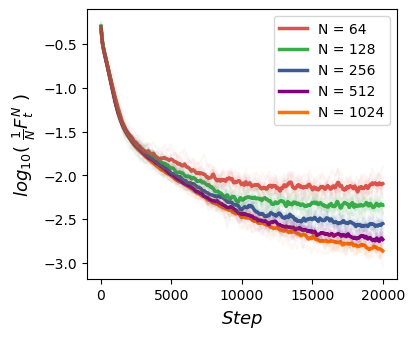

In [54]:
# log 2 loss versus interation numbers, different test var, restore the test info at first

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

test_var = 'particle_num'
try:
    print(test_values)
except:
    test_values = [32,64,128,256,512]
test_values = [64,128,256,512,1024]

log_wise_step = False
log_wise_loss = True
minus_minimum = False

# colors = sns.color_palette("Paired")[1:len(test_values)+1]
colors = [sns.xkcd_rgb['pale red'],sns.xkcd_rgb['medium green'], sns.xkcd_rgb['denim blue'],'purple',sns.xkcd_rgb['orange'],'yellow','black','brown']


fig = plt.figure(figsize=(4,3.5))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']

for idx, losses in enumerate([result_trainloss_set, result_L2_trainloss_set]):
    if idx == 1:
        continue
    ax = axs[idx]
    losses = np.array(losses)

    I = np.array(losses).shape[-1]

    eps = 1e-6
    smooth_window_size = 111
    obser_end = int(losses.shape[-1] * 1) 

    xplot_set = np.arange(I) if log_wise_loss else np.arange(I-1)

    for idx_ in range(len(test_values)):

        globals()[test_var] = test_values[idx_]

        xplot_set = np.log2(np.arange(1,I+1)) if log_wise_step else np.arange(I)

        for pending_list in losses[idx_]:

            yplot_set = smooth_loss(pending_list, window_size  = smooth_window_size)
            yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)

            ax.plot(xplot_set[:obser_end],yplot_set[:obser_end],c=colors[idx_],alpha=0.05,zorder = 1)

        yplot_set = np.mean(losses[idx_],axis=0)
        yplot_set = smooth_loss(yplot_set, window_size  = smooth_window_size)
        yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)

        ax.plot(xplot_set[:obser_end],yplot_set[:obser_end],linewidth = 2.5,
                 zorder = -idx_,c=colors[idx_],label='N = %d'%(test_values[idx_]))

    ax.legend(loc = 'upper right',ncol=1)
#     ax.set_ylim(-8,-6)
    ax.set_xlabel('$log_2 (Step)$') if log_wise_step else plt.xlabel('$Step$',fontsize=13)
    ax.set_ylabel('$log_{10} (\ \\frac{1}{N} F_t^N\ )$',fontsize=13) 
    
plt.savefig('sigmoid_paths.pdf', bbox_inches='tight')
plt.show()



## Fitting

In [55]:
from sklearn import linear_model

trained_losses = []
L2_trained_losses = []

for idx, test_vulue in enumerate(test_values):
    trained_losses_current = []
    L2_trained_losses_current = []
    
    for test_number in range(len(result_trainloss_set[idx])):
        trained_losses_current.append(np.mean(result_trainloss_set[idx][test_number][-500:]))
        L2_trained_losses_current.append(np.mean(result_L2_trainloss_set[idx][test_number][-500:]))
        
    trained_losses.append(trained_losses_current)
    L2_trained_losses.append(L2_trained_losses_current)
    


## Fixed alpha regression

In [56]:
test_time_per_objective = len(trained_losses_current)
try:
    print(test_values)
except:
    test_values = [32,64,128,256,512]

test_values = np.array([test_values])
all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
trained_losses = np.array(trained_losses)
L2_trained_losses =  np.array(L2_trained_losses)

model = linear_model.LinearRegression()
alpha = -1.0

model.fit(all_data.reshape(-1,1)**(alpha), trained_losses.reshape(-1))
w = model.coef_[0]
b = model.intercept_

model = linear_model.LinearRegression()
alpha_l2 = -1.0
          
model.fit(all_data.reshape(-1,1)**(alpha_l2), L2_trained_losses.reshape(-1))
w_l2 = model.coef_[0]
b_l2 = model.intercept_


[64, 128, 256, 512, 1024]


## Freed alpha fit

In [14]:
from scipy.optimize import minimize


def loss(param):
    C_1 = param[0]
    C_2 = param[1]
    alpha = param[2]
    return np.mean((L2_trained_losses.reshape(-1) - C_1 - C_2 * all_data ** (alpha) )**2)

method = 'BFGS'
result = minimize(loss, x0=[0,0,0], method = method)
print(result)

b_l2, w_l2, alpha_l2 =  result.x

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.1227823228408375e-06
        x: [ 2.510e-02  3.841e+00 -1.057e+00]
      nit: 41
      jac: [ 3.759e-07 -4.387e-08 -4.599e-07]
 hess_inv: [[ 2.759e+00  9.840e+02 -8.175e+01]
            [ 9.840e+02  5.909e+05 -4.639e+04]
            [-8.175e+01 -4.639e+04  3.679e+03]]
     nfev: 188
     njev: 47


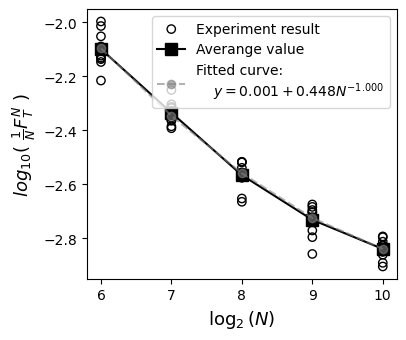

In [58]:
# log 2 terminal loss versus different test var

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

fig = plt.figure(figsize=(4,3.5))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
ws = [w, w_l2]
bs = [b, b_l2]
alphas = [alpha, alpha_l2]
logwise_loss = True

for idx, trained_losses_data in enumerate([trained_losses, L2_trained_losses]):
    if idx == 1:
        continue
    ax = axs[idx]
    w_plot = ws[idx]
    b_plot = bs[idx]
    alpha_plot = alphas[idx]
    
    avg_trained_loss_vec = np.mean(trained_losses_data,axis=1)

    all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
    
    xplot_all = np.log2(all_data.copy()) if logwise_loss else all_data.copy()
    xplot = np.log2(test_values.reshape(-1).copy()) if logwise_loss else test_values.reshape(-1).copy()
    yplot_all = np.log10(trained_losses_data.reshape(-1).copy()) if logwise_loss else trained_losses_data.reshape(-1).copy()
    yplot =  np.log10(avg_trained_loss_vec.copy())if logwise_loss else avg_trained_loss_vec.copy()
    yplot_predict = np.log10(b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)) if logwise_loss else b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)
    
    ax.scatter(xplot_all,yplot_all,color='none',marker='o',edgecolors='k',linewidths=1,label='Experiment result')
    ax.plot(xplot,yplot,c='k',marker='s',markersize=8,label='Averange value')
    ax.plot(xplot, yplot_predict,'--', marker='o', c= 'grey', label='Fitted curve: \n    $y= %.3f + %.3f N^{%.3f}$'%(b_plot,w_plot,alpha_plot),alpha=0.6)

    ax.legend()
    
    if logwise_loss:
        ax.set_xlabel('$\log_{2} (N)$',fontsize=13)
        ax.set_ylabel('$log_{10} (\ \\frac{1}{N} F_T^N\ )$',fontsize=13) 
    else:
        ax.set_xlabel('$N$')
        ax.set_ylabel('$%s$'%(labels[idx]),) 
        
plt.savefig('sigmoid_losses.pdf', bbox_inches='tight')
plt.show()


##  Cross Validate

In [21]:

import torch
from matplotlib import pyplot as plt
from torch import nn, optim
# from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
 
# 超参数
batch_size = 256  # 批大小
learning_rate = 0.0001  # 学习率
epochs = 20  # 迭代次数
channels = 1  # 图像通道大小
 
# 数据集下载和预处理
transform = transforms.Compose([transforms.ToTensor(),  # 将图片转换成PyTorch中处理的对象Tensor,并且进行标准化0-1
                                transforms.Normalize([0.5], [0.5])])  # 归一化处理
path = './data/'  # 数据集下载后保存的目录
# 下载训练集和测试集
trainData = datasets.MNIST(path, train=True, transform=transform, download=True)
testData = datasets.MNIST(path, train=False, transform=transform)
# 处理成data loader
trainDataLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=batch_size, shuffle=True)  # 批量读取并打乱
testDataLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=batch_size)
 
 
# 开始构建cnn模型
class cnn(torch.nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.model = torch.nn.Sequential(
            # The size of the picture is 28*28
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
 
            # The size of the picture is 14*14
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            #
            # The size of the picture is 7*7
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(kernel_size=2, stride=2),
 
            # The size of the picture is 7*7
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(kernel_size=2, stride=2),
 
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=7 * 7 * 256, out_features=512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),  # 抑制过拟合 随机丢掉一些节点
            torch.nn.Linear(in_features=512, out_features=10),
            # torch.nn.Softmax(dim=1) # pytorch的交叉熵函数其实是softmax-log-NLL 所以这里的输出就不需要再softmax了
        )
 
    def forward(self, input):
        output = self.model(input)
        return output
 
 
# 选择模型
model = cnn()
# GPU可用时转到cuda上执行
if torch.cuda.is_available():
    model = model.cuda()
 
criterion = nn.CrossEntropyLoss()  # 选用交叉熵函数作为损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters())
 
# 训练模型并存储训练时的指标
epoch = 1
history = {'Train Loss': [],
           'Test Loss': [],
           'Train Acc': [],
           'Test Acc': []}
for epoch in range(1, epochs+1):
    processBar = tqdm(trainDataLoader, unit='step')
    model.train(True)
    train_loss, train_correct = 0, 0
    for step, (train_imgs, labels) in enumerate(processBar):
 
        if torch.cuda.is_available():  # GPU可用
            train_imgs = train_imgs.cuda()
            labels = labels.cuda()
        model.zero_grad()  # 梯度清零
        outputs = model(train_imgs)  # 输入训练集
        loss = criterion(outputs, labels)  # 计算损失函数
        predictions = torch.argmax(outputs, dim=1)  # 得到预测值
        correct = torch.sum(predictions == labels)
        accuracy = correct / labels.shape[0]  # 计算这一批次的正确率
        loss.backward()  # 反向传播
        optimizer.step()  # 更新优化器参数
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" %  # 可视化训练进度条设置
                                   (epoch, epochs, loss.item(), accuracy.item()))
 
        # 记录下训练的指标
        train_loss = train_loss + loss
        train_correct = train_correct + correct
 
        # 当所有训练数据都进行了一次训练后，在验证集进行验证
        if step == len(processBar) - 1:
            tst_correct, totalLoss = 0, 0
            model.train(False)  # 开始测试
            model.eval()  # 固定模型的参数并在测试阶段不计算梯度
            with torch.no_grad():
                for test_imgs, test_labels in testDataLoader:
                    if torch.cuda.is_available():
                        test_imgs = test_imgs.cuda()
                        test_labels = test_labels.cuda()
                    tst_outputs = model(test_imgs)
                    tst_loss = criterion(tst_outputs, test_labels)
                    predictions = torch.argmax(tst_outputs, dim=1)
 
                    totalLoss += tst_loss
                    tst_correct += torch.sum(predictions == test_labels)
 
                train_accuracy = train_correct / len(trainDataLoader.dataset)
                train_loss = train_loss / len(trainDataLoader)  # 累加loss后除以步数即为平均loss值
 
                test_accuracy = tst_correct / len(testDataLoader.dataset)  # 累加正确数除以样本数即为验证集正确率
                test_loss = totalLoss / len(testDataLoader)  # 累加loss后除以步数即为平均loss值
 
                history['Train Loss'].append(train_loss.item())  # 记录loss和acc
                history['Train Acc'].append(train_accuracy.item())
                history['Test Loss'].append(test_loss.item())
                history['Test Acc'].append(test_accuracy.item())
 
                processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %
                                           (epoch, epochs, train_loss.item(), train_accuracy.item(), test_loss.item(),
                                            test_accuracy.item()))
    processBar.close()

plt.plot(history['Test Loss'], color='red', label='Test Loss')
plt.plot(history['Train Loss'], label='Train Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.xlim([0, epoch])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Loss')
plt.title('Train and Test LOSS')
plt.legend(loc='upper right')
plt.savefig('LOSS')
plt.show()
 
plt.plot(history['Test Acc'], color='red', label='Test Acc')
plt.plot(history['Train Acc'], label='Train Acc')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.xlim([0, epoch])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Accuracy')
plt.title('Train and Test ACC')
plt.legend(loc='lower right')
plt.savefig('ACC')
plt.show()
 


[1/20] Loss: 0.5577, Acc: 0.8501, Test Loss: 0.1394, Test Acc: 0.9563: 100%|███████| 235/235 [00:17<00:00, 13.64step/s]
[2/20] Loss: 0.1231, Acc: 0.9648:  44%|███████████████████▎                        | 103/235 [00:06<00:07, 16.76step/s]


KeyboardInterrupt: 

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the batch size for training and testing
batch_size = 128

# Define the transformation to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network model
model = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Train the model
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {} - Training loss: {}".format(epoch+1, running_loss/len(train_loader)))

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print("Accuracy on the test set: {:.2f}%".format(100 * correct / total))

RuntimeError: The size of tensor a (10) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
# test

In [151]:
net = Net(N=1,cut_off=cut_off,activation_type ='ReLU').to(device)

In [152]:
data = torch.Tensor([[0,0],[0,0]]).cuda()

In [153]:
net(data)

tensor([[1.0766],
        [1.0766]], device='cuda:0', grad_fn=<MmBackward0>)

In [154]:
target = torch.sin(2 * np.pi * data[:,0]) + torch.cos(2 * np.pi * data[:,1])
target

tensor([1., 1.], device='cuda:0')

In [155]:
predict = net(data).view(-1)

In [157]:
loss = ((predict - target) **2).mean()
loss

tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)

In [158]:
loss.backward()

In [159]:
net.fc1(data)

tensor([[1.2332],
        [1.2332]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [162]:
err = target-net(data).view(-1)

In [163]:
err

tensor([-0.0766, -0.0766], device='cuda:0', grad_fn=<SubBackward0>)

In [164]:
layer_params = net.fc1.parameters()

# Print the parameters
for param in layer_params:
    print(param)


Parameter containing:
tensor([[0.3973, 0.3350]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.2332], device='cuda:0', requires_grad=True)


In [165]:
layer_params = net.fc2.parameters()

# Print the parameters
for param in layer_params:
    print(param)

Parameter containing:
tensor([[0.8730]], device='cuda:0', requires_grad=True)


In [166]:
for name, param in net.named_parameters():
    if param.grad is not None:
        print(f"Gradient for parameter {name}:")
        print(param.grad)

Gradient for parameter fc1.weight:
tensor([[0., 0.]], device='cuda:0')
Gradient for parameter fc1.bias:
tensor([0.1338], device='cuda:0')
Gradient for parameter fc2.weight:
tensor([[0.1890]], device='cuda:0')
